🚀 Memproses gambar dengan OpenPose...
✅ Proses OpenPose selesai!
🔍 Isi folder output_images: ['.ipynb_checkpoints', 'IMG-20250228-WA0002_rendered.png']
✅ Sudut Lutut: 86.08°
✅ Sudut Siku: 136.13°
✅ Sudut Leher: 175.02°
✅ Sudut Paha-Punggung: 92.80°
✅ Sudut Pergelangan Tangan: 0.98°
✅ Sudut Fleksi/Ekstensi Bahu: 44.09°


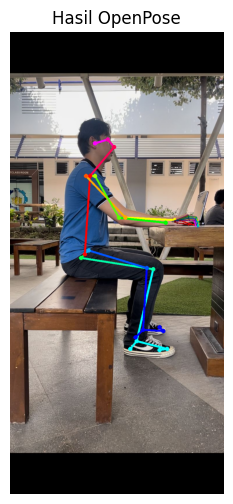

In [4]:
import os
import cv2
import numpy as np
import subprocess
import json
import matplotlib.pyplot as plt

# Fungsi untuk menghitung sudut menggunakan cosine rule
def calculate_angle(a, b, c):
    a = np.array(a)  # Titik pertama
    b = np.array(b)  # Titik tengah (sendi)
    c = np.array(c)  # Titik ketiga
    
    # Vektor
    v1 = a - b
    v2 = c - b
    
    # Cosine Rule
    cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    
    return np.degrees(angle)

# Tentukan path utama untuk OpenPose dan gambar (gunakan path absolut)
openpose_path = os.path.abspath("openpose")  # Path OpenPose
image_dir = os.path.abspath("../images")  # Path ke folder gambar
output_dir = os.path.abspath("../output_images")  # Path output OpenPose
json_output_dir = os.path.abspath("../output_json")  # Path JSON output OpenPose

os.makedirs(image_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(json_output_dir, exist_ok=True)

# Ambil file gambar yang sudah diunggah ke folder `images/`
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

if not image_files:
    print("⚠️ Tidak ada gambar yang valid di folder `images/`. Silakan unggah file JPG atau PNG!")
    exit()

# Ambil file pertama dari folder images
input_image_path = os.path.join(image_dir, image_files[0])
file_name, file_ext = os.path.splitext(image_files[0])

# Tentukan nama output yang sesuai format OpenPose
output_image_name = f"{file_name}_rendered.png"
output_image_path = os.path.join(output_dir, output_image_name)
output_json_path = os.path.join(json_output_dir, file_name + '_keypoints.json')

# Jalankan OpenPose dengan `cwd=openpose_path`
cmd = [
    "bin\\OpenPoseDemo.exe",
    "--image_dir", image_dir,
    "--write_images", output_dir,
    "--write_json", json_output_dir,
    "--display", "0",
    "--render_pose", "1",
    "--model_pose", "BODY_25",
    "--hand",
    "--number_people_max", "1"
]

print("🚀 Memproses gambar dengan OpenPose...")

# Jalankan OpenPose dalam folder `openpose`
result = subprocess.run(cmd, shell=True, capture_output=True, text=True, cwd=openpose_path)

# Jika ada error, tampilkan log
if result.returncode != 0:
    print("❌ Terjadi kesalahan saat menjalankan OpenPose!")
    print("Error Log:", result.stderr)
    exit()
else:
    print("✅ Proses OpenPose selesai!")

# Debugging: Cek isi folder output
print("🔍 Isi folder output_images:", os.listdir(output_dir))

# Baca hasil JSON dari OpenPose untuk keypoints
if os.path.exists(output_json_path):
    with open(output_json_path, 'r') as f:
        pose_data = json.load(f)
        keypoints = pose_data['people'][0]['pose_keypoints_2d']
        hand_keypoints = pose_data['people'][0].get('hand_right_keypoints_2d', [])  # Hanya tangan kanan
else:
    print("❌ JSON hasil deteksi tidak ditemukan!")
    keypoints = None
    hand_keypoints = None

if keypoints:
    # Ambil koordinat yang diperlukan (x, y, confidence)
    def get_coords(index):
        return (keypoints[index * 3], keypoints[index * 3 + 1]) if keypoints[index * 3 + 2] > 0 else None

    # Fungsi untuk mendapatkan koordinat titik tangan kanan
    def get_hand_coords(index):
        return (hand_keypoints[index * 3], hand_keypoints[index * 3 + 1]) if hand_keypoints and len(hand_keypoints) > index * 3 + 2 and hand_keypoints[index * 3 + 2] > 0 else None

    # Titik-titik tubuh yang dibutuhkan
    hip = get_coords(9)      # Pinggul
    knee = get_coords(10)     # Lutut
    ankle = get_coords(11)   # Pergelangan kaki
    shoulder = get_coords(2) # Bahu kanan
    elbow = get_coords(3)    # Siku kanan
    wrist = get_coords(4)    # Pergelangan tangan kanan
    neck = get_coords(1)     # Leher
    head = get_coords(17)     # Kepala
    back = get_coords(8)     # Punggung atas (di antara bahu dan pinggul)

    # Titik tangan kanan yang dibutuhkan
    thumb = get_hand_coords(4)       # Ibu jari
    index_finger = get_hand_coords(8) # Jari telunjuk
    pinky = get_hand_coords(20)       # Jari kelingking

    # Hitung sudut tubuh utama
    if hip and knee and ankle:
        knee_angle = calculate_angle(hip, knee, ankle)
        print(f"✅ Sudut Lutut: {knee_angle:.2f}°")
    
    if shoulder and elbow and wrist:
        elbow_angle = calculate_angle(shoulder, elbow, wrist)
        print(f"✅ Sudut Siku: {elbow_angle:.2f}°")
    
    if back and neck and head:
        neck_angle = calculate_angle(back, neck, head)
        print(f"✅ Sudut Leher: {neck_angle:.2f}°")
    
    if knee and hip and neck:
        thigh_back_angle = calculate_angle(knee, hip, neck)
        print(f"✅ Sudut Paha-Punggung: {thigh_back_angle:.2f}°")

    # Hitung sudut pergelangan tangan kanan
    if wrist and thumb and pinky:
        wrist_angle = calculate_angle(thumb, wrist, pinky)
        print(f"✅ Sudut Pergelangan Tangan: {wrist_angle:.2f}°")

    # Hitung sudut bahu
    if back and shoulder and elbow:
        shoulder_angle = calculate_angle(back, shoulder, elbow)
        print(f"✅ Sudut Fleksi/Ekstensi Bahu: {shoulder_angle:.2f}°")

# Cek hasilnya dan langsung tampilkan gambar dengan nama yang benar
if os.path.exists(output_image_path):
    img = cv2.imread(output_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Hasil OpenPose")
    plt.show()
else:
    print(f"⚠️ Gagal menemukan gambar output: {output_image_path}. Coba cek folder `output_images/` secara manual.")
